# LSTM/GRU/MLP univariate/multivariate

### Create 2d array

In [501]:
import numpy as np
import pandas as pd

# Choose frequency, binsize, longitude, latitude
freq = 'M'
binsize = 2
longitude_W = 134 # minimum is 134
longitude_E = 174 # maximum is 174
latitude_S = 10 # minimum is 10
latitude_N = 60 # minimum is 60

# load earthquake data for defined area
data = pd.read_csv('data/Japan_10_60_134_174_1973_2023_V2.csv', index_col=0)
data['Time'] = pd.to_datetime(data.Time)
data = data[(data.Longitude >= longitude_W) & (data.Longitude <= longitude_E) & (data.Latitude >= latitude_S) & (data.Latitude <= latitude_N)]
data.set_index('Time', inplace=True)
df = data.sort_index()

# Bin the longitude and latitude values into 2x2 degree bins
df['Longitude_bin'] = pd.cut(df['Longitude'], bins=np.arange(longitude_W, longitude_E+1, binsize))  # Change bin size to 2 degrees
df['Latitude_bin'] = pd.cut(df['Latitude'], bins=np.arange(latitude_S, latitude_N+1, binsize))  # Change bin size to 2 degrees

# Group the data by longitude bin, latitude bin, depth bin, and day, and compute the maximum magnitude within each group
grouped = df.groupby(['Longitude_bin', 'Latitude_bin', pd.Grouper(freq=freq, level="Time")]).max()['Magnitude']
grouped = grouped.unstack().fillna(0)

# Reshape the resulting data into a tensor with shape (1, time, depth, longitude, latitude)
time = len(grouped.columns)
longitude = len(grouped.index.levels[0])
latitude = len(grouped.index.levels[1])
tensor = np.zeros((time, longitude, latitude))

for t in range(time):
    tensor[t, :, :] = grouped.iloc[:, t].values.reshape(longitude, latitude)

# Rotate dimensions corresponding to 20 and 25, 90 degrees anti-clockwise
tensor = np.transpose(tensor, axes=(0, 2, 1))
tensor = np.flip(tensor, axis=1)

# Print the shape of the resulting tensor
print(tensor.shape)

# Reshape tensor into matrix
matrix = np.reshape(tensor, (tensor.shape[0], -1))

# Keep only the columns with at least one number bigger than 0
matrix = matrix[:, (matrix > 0).sum(axis=0) >= 0]
balance = 1 - (matrix >= 4.5).flatten().sum() / len(matrix.flatten())
print(matrix.shape, "mean:", matrix[matrix > 0].mean(), balance)

(600, 25, 20)
(600, 500) mean: 4.661273802211302 0.9443933333333333


### Select most active sub-region

In [502]:
df_transformed = pd.DataFrame(matrix).set_index(grouped.T.index)

active_column = df_transformed.sum(axis=0).argmax()
active_sub = df_transformed[active_column]
active_vec = np.reshape(np.array(active_sub), (-1, 1))
# print column number with highest sum
print("column with highest sum of magnitudes:", active_column)

column with highest sum of magnitudes: 223


Text(0.5, 1.0, 'Earthquakes for selected sub-regions')

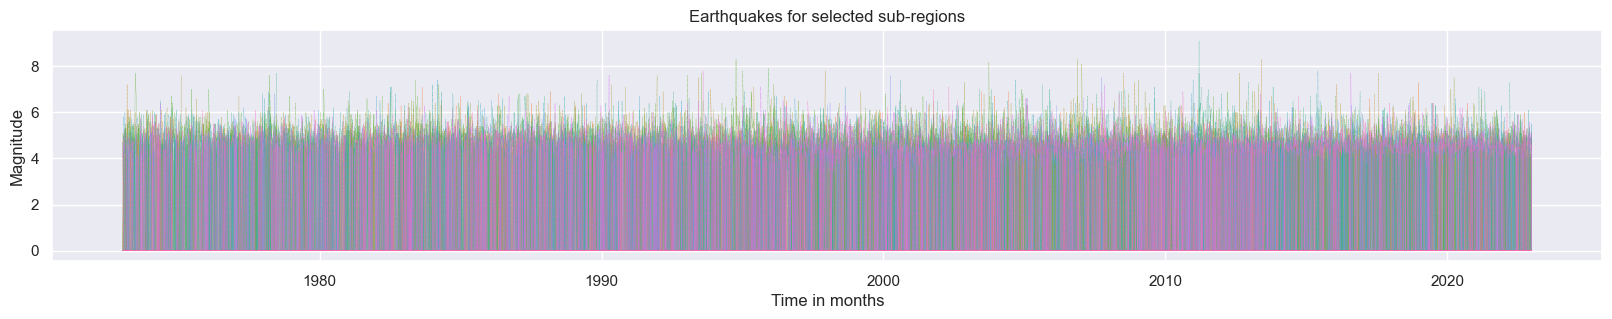

In [494]:
import seaborn as sns
import numpy as np

sns.set(rc={'figure.figsize':(20,3)})
plot = sns.lineplot(data=df_transformed[df_transformed >= 0], linewidth = .2, legend=False)
plot.set_xlabel("Time in months")
plot.set_ylabel("Magnitude")
plot.set_title("Earthquakes for selected sub-regions")

### Splitting the data

In [503]:
from sklearn.model_selection import train_test_split

# split data in train, val, test

# Activate when only forecasting one region
# matrix = np.reshape(matrix, (matrix.shape[0], matrix.shape[1], 1))

train, val_test = train_test_split(matrix, test_size=.3, shuffle=False, random_state=43)
val, test = train_test_split(val_test, test_size=.5, shuffle=False, random_state=43)

### Generate datasets from timeseries V1 (not shuffled)

In [618]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf

def dataset_generator(data, seq_length, cutoff):

  input_data = data # data[:-seq_length]
  targets = data[seq_length:]
  dataset = timeseries_dataset_from_array(input_data, (targets >= cutoff).astype(int), sequence_length=seq_length, sampling_rate=1, sequence_stride=1, shuffle=False, batch_size=len(data))
  """
  for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], data[:seq_length])  # First sequence: steps [0-9]
    assert np.array_equal(targets[0], data[seq_length])  # Corresponding target: step 10
    """
  return dataset

# Set lookback timewindow
timewindow = 24
cutoff = 4.5

train_dataset = dataset_generator(train, timewindow, cutoff)
val_dataset = dataset_generator(val, timewindow, cutoff)
test_dataset = dataset_generator(test, timewindow, cutoff)

# Create train set
for batch in train_dataset:
    X_train, y_train = batch

# y_train = tf.reshape(y_train, shape=[y_train.shape[0], 1, y_train.shape[1]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
# y_train = tf.cast(tf.reduce_max(y_train, axis=2, keepdims=True) > 0, dtype=tf.int32)

# Create validation set
for batch in val_dataset:
    X_val, y_val = batch

# y_val = tf.reshape(y_val, shape=[y_val.shape[0], 1, y_val.shape[1]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
# y_val = tf.cast(tf.reduce_max(y_val, axis=2, keepdims=True) > 0, dtype=tf.int32)

# Create test set
for batch in test_dataset:
    X_test, y_test = batch

# y_test = tf.reshape(y_test, shape=[y_test.shape[0], 1, y_test.shape[1]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
# y_test = tf.cast(tf.reduce_max(y_test, axis=2, keepdims=True) > 0, dtype=tf.int32)

################################# Use for MLP
# Flatten 1 and 2 dimensions of X's for multivariate MLP
# X_train = np.reshape(X_train, (X_train.shape[0],-1))
# X_val = np.reshape(X_val, (X_val.shape[0],-1))
# X_test = np.reshape(X_test, (X_test.shape[0],-1))

X_test.shape, y_test.shape

(TensorShape([66, 24, 500]), TensorShape([66, 500]))

## Construct LSTM (univariate/multivariate)

In [619]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Flatten, Input, TimeDistributed, Dropout, RepeatVector, BatchNormalization
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import backend as K

keras.backend.clear_session()

# define model
model = Sequential()

model.add(BatchNormalization())
model.add(LSTM(256, activation='LeakyReLU',
               return_sequences=False,
               input_shape=(X_train.shape[1], X_train.shape[2]),
               kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
               bias_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
               dropout=0.4
               ))

model.add(BatchNormalization())

"""
model.add(Dense(12, input_dim=(X_train.shape[1]), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(12, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(12, activation='relu'))
model.add(BatchNormalization())
"""
model.add(Dense(256, activation='LeakyReLU'))
model.add(Dense(500, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryFocalCrossentropy( apply_class_balancing=True, alpha=balance, gamma=2)
model.compile(optimizer=opt, loss=loss, metrics=[keras.metrics.Precision(), keras.metrics.Recall()])



### fit model

In [620]:
# early stopping
callback = EarlyStopping(monitor='val_loss', patience=5)
# fit model
history = model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_val,y_val),
                    steps_per_epoch=12,
                    batch_size=32,
                    epochs=100,
                    verbose=1,
                    callbacks=[callback])

Epoch 1/100
12/12 [==============================] - 2s 54ms/step - loss: 1.4713 - precision: 0.0882 - recall: 0.6469 - val_loss: 1.1722 - val_precision: 0.1834 - val_recall: 0.7974
Epoch 2/100
12/12 [==============================] - 0s 40ms/step - loss: 0.9433 - precision: 0.2190 - recall: 0.8804 - val_loss: 0.7276 - val_precision: 0.2963 - val_recall: 0.8875
Epoch 3/100
12/12 [==============================] - 1s 48ms/step - loss: 0.5595 - precision: 0.2736 - recall: 0.9302 - val_loss: 0.4054 - val_precision: 0.3276 - val_recall: 0.8902
Epoch 4/100
12/12 [==============================] - 1s 47ms/step - loss: 0.2936 - precision: 0.2816 - recall: 0.9386 - val_loss: 0.2000 - val_precision: 0.3409 - val_recall: 0.9028
Epoch 5/100
12/12 [==============================] - 1s 47ms/step - loss: 0.1406 - precision: 0.2824 - recall: 0.9434 - val_loss: 0.1055 - val_precision: 0.3457 - val_recall: 0.8915
Epoch 6/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0901 - precisi

### predict

In [621]:
y_pred = model.predict(X_test)

# y_pred = scaler.inverse_transform(y_pred)
# y_test = scaler.inverse_transform(test)

3/3 [==============================] - 0s 11ms/step


### evaluation metrics

In [622]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(np.array(y_test).flatten(), y_pred.flatten() >= .5)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(np.array(y_test).flatten(), y_pred.flatten() >= .5)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(np.array(y_test).flatten(), y_pred.flatten() >= .5)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(np.array(y_test).flatten(), y_pred.flatten() >= .5)
print('F1 score: %f' % f1)

class_names = ['M<4.5', 'M>=4.5']

print(classification_report(np.array(y_test).flatten(), y_pred.flatten() >= .5, target_names=class_names))

# Calculate the proportion of the majority per row, column combination over all batches
majority_prop = np.mean(test >= cutoff, axis=0)[:]

# Calculate the complement for values lower than 0.5
majority_prop = np.where(majority_prop < 0.5, 1 - majority_prop, majority_prop)
zeroR = majority_prop.mean()

print("zeroR:", round(zeroR,4))

Accuracy: 0.898000
Precision: 0.382892
Recall: 0.848375
F1 score: 0.527645
              precision    recall  f1-score   support

       M<4.5       0.99      0.90      0.94     30784
      M>=4.5       0.38      0.85      0.53      2216

    accuracy                           0.90     33000
   macro avg       0.69      0.87      0.74     33000
weighted avg       0.95      0.90      0.91     33000

zeroR: 0.9496


### confusion matrix

[Text(0, 0.5, 'M<6'), Text(0, 1.5, 'M>=6')]

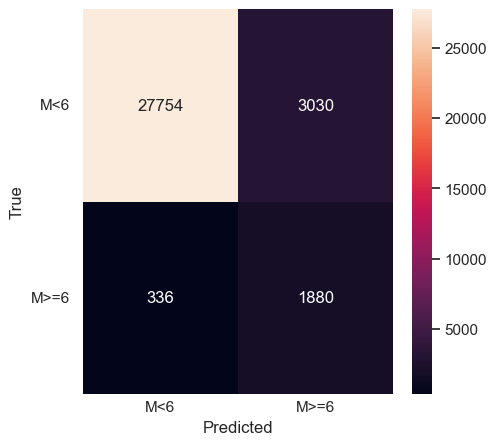

In [623]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set(rc={'figure.figsize':(5,5)})
p = sns.heatmap(confusion_matrix(np.array(y_test).flatten(), y_pred.flatten() >= .5), annot=True, fmt='g')
p.set_xlabel("Predicted")
p.set_ylabel("True")
p.xaxis.set_ticklabels(['M<6', 'M>=6'], ha="center", va="center")
p.yaxis.set_ticklabels(['M<6', 'M>=6'], rotation=0, va="center")

### ROC curve

3/3 [==============================] - 0s 11ms/step


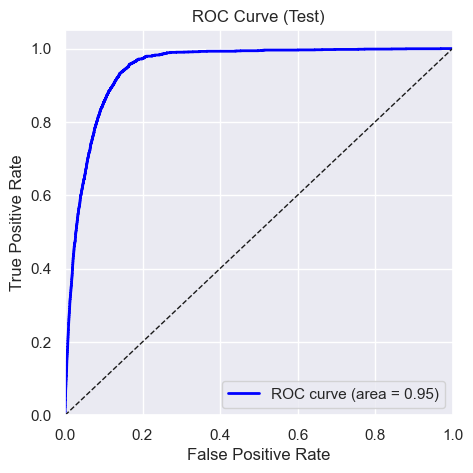

In [624]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_ROC_AUC(X,y):

    # Use the trained model to predict the class probabilities for the validation set
    y_prob = model.predict(X)
    # y_pred = scaler.inverse_transform(y_prob)
    # y_test = scaler.inverse_transform(y)

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(np.array(y_test).flatten(), y_pred.flatten())
    roc_auc = auc(fpr, tpr)

    # Plot micro-average ROC curve
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
            ''.format(roc_auc), color='blue', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    # plt.savefig(savefig)
    plt.show()

plot_ROC_AUC(X_test, y_test)

### Plot predicted against true

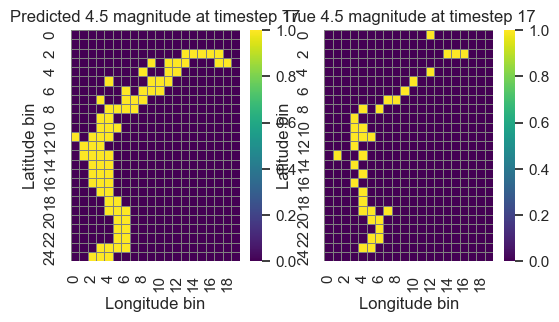

In [628]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape data to grid
y_pred = np.reshape(y_pred, (y_pred.shape[0], tensor.shape[1], tensor.shape[2]))
y_test= np.reshape(y_test, (y_test.shape[0], tensor.shape[1], tensor.shape[2]))

# Choose timesteps to plot
timestep = 17


# Extract the data for the chosen timesteps from the tensor
data1 = y_pred[timestep, :, :] >= 0.5
data2 = y_test[timestep, :, :]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 3))

# Plot the data in each subplot
sns.heatmap(data1, cmap='viridis', vmin=0, vmax=1, linewidths=0.5, linecolor='grey', annot=False, ax=ax1)
sns.heatmap(data2, cmap='viridis', vmin=0, vmax=1, linewidths=0.5, linecolor='grey', annot=False, ax=ax2)

# Set the plot titles and axis labels
ax1.set_title(f'Predicted {cutoff} magnitude at timestep {timestep}')
ax1.set_xlabel('Longitude bin')
ax1.set_ylabel('Latitude bin')

ax2.set_title(f'True {cutoff} magnitude at timestep {timestep}')
ax2.set_xlabel('Longitude bin')
ax2.set_ylabel('Latitude bin')

# Show the plot
plt.show()